In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import options, NDX, and rates data

In [2]:
# import options data
data = pd.read_csv("NDXP.csv").sort_values(by=['quote_date', 'strike']).reset_index(drop = True)
data['quote_date'] = pd.to_datetime(data['quote_date'])
data['expiration'] = pd.to_datetime(data['expiration'])
data

,quote_date,expiration,strike,option_type,bid_1545,ask_1545
0,2018-01-04,2018-02-02,6200.0,C,401.9,423.0
1,2018-01-04,2018-02-02,6200.0,P,11.8,16.0
2,2018-01-04,2018-02-09,6200.0,C,406.2,427.0
3,2018-01-04,2018-02-09,6200.0,P,18.7,23.0
4,2018-01-04,2018-02-23,6200.0,C,417.5,439.0
...,...,...,...,...,...,...
7226456,2022-12-30,2023-01-06,16000.0,P,5106.0,5122.1
7226457,2022-12-30,2023-01-13,16000.0,C,0.0,0.9
7226458,2022-12-30,2023-01-13,16000.0,P,5089.8,5106.2
7226459,2022-12-30,2023-01-27,16000.0,C,0.0,1.2


In [3]:
NDX_100 = pd.read_csv('NDX100_Data.csv')
NDX_100.rename(columns = {'Close/Last':'NDX_Exp'}, inplace = True)
NDX_100['Date'] = pd.to_datetime(NDX_100['Date'])
NDX_100

,Date,NDX_Exp
0,2024-01-05,16305.98
1,2024-01-04,16282.01
2,2024-01-03,16368.49
3,2024-01-02,16543.94
4,2023-12-29,16825.93
...,...,...
2530,2014-01-10,3565.08
2531,2014-01-09,3552.58
2532,2014-01-08,3567.54
2533,2014-01-07,3557.85


In [4]:
# import interest rate data
rates = pd.read_csv("DGS1MO.csv").ffill()
rates.replace('.', pd.NA, inplace=True)
rates.columns = ['date','rate']
rates['date'] = pd.to_datetime(rates['date'])
rates['rate'] = (pd.to_numeric(rates['rate'])/100).fillna(method='ffill')
rates

,date,rate
0,2018-01-02,0.0129
1,2018-01-03,0.0129
2,2018-01-04,0.0128
3,2018-01-05,0.0127
4,2018-01-08,0.0130
...,...,...
1299,2022-12-26,0.0380
1300,2022-12-27,0.0387
1301,2022-12-28,0.0386
1302,2022-12-29,0.0404


## Filter for second fridays (and thursdays if fridays don't exist)

In [5]:
# second fridays between 2018 and 2022

all_fridays = pd.date_range(start="2018-01-01", end="2022-12-31", freq='W-FRI') ## all fridays in the period

second_fridays = [] # initialize second fridays list

for friday in all_fridays: # loop through every friday and determine if it is second friday
    month_start = pd.offsets.MonthBegin(1) # create a date offset to move friday to start of the month
    if len(pd.date_range(start = friday - month_start, end = friday, freq='W-FRI')) == 2: # if number of fridays since start of month is 2:
        second_fridays.append(friday)

second_fridays = pd.Series(second_fridays)
old_date = pd.to_datetime('2020-04-10') # replace missing friday with thursday
new_date = pd.to_datetime('2020-04-09')
index = second_fridays[second_fridays == old_date].index
second_fridays.at[index[0]] = new_date
second_fridays

0    2018-01-12
1    2018-02-09
2    2018-03-09
3    2018-04-13
4    2018-05-11
5    2018-06-08
6    2018-07-13
7    2018-08-10
8    2018-09-14
9    2018-10-12
10   2018-11-09
11   2018-12-14
12   2019-01-11
13   2019-02-08
14   2019-03-08
15   2019-04-12
16   2019-05-10
17   2019-06-14
18   2019-07-12
19   2019-08-09
20   2019-09-13
21   2019-10-11
22   2019-11-08
23   2019-12-13
24   2020-01-10
25   2020-02-14
26   2020-03-13
27   2020-04-09
28   2020-05-08
29   2020-06-12
30   2020-07-10
31   2020-08-14
32   2020-09-11
33   2020-10-09
34   2020-11-13
35   2020-12-11
36   2021-01-08
37   2021-02-12
38   2021-03-12
39   2021-04-09
40   2021-05-14
41   2021-06-11
42   2021-07-09
43   2021-08-13
44   2021-09-10
45   2021-10-08
46   2021-11-12
47   2021-12-10
48   2022-01-14
49   2022-02-11
50   2022-03-11
51   2022-04-08
52   2022-05-13
53   2022-06-10
54   2022-07-08
55   2022-08-12
56   2022-09-09
57   2022-10-14
58   2022-11-11
59   2022-12-09
dtype: datetime64[ns]

In [6]:
# get second-friday expirations
second_friday_exp = data[data['expiration'].isin(second_fridays)]
day_difference = (second_friday_exp['expiration'] - second_friday_exp['quote_date']).dt.days
data_28_days = second_friday_exp[day_difference == 28]
unmatched_expiration_dates = second_friday_exp.loc[~second_friday_exp['expiration'].isin(data_28_days['expiration']), 'expiration']
data_29_days = second_friday_exp[(day_difference == 29) & second_friday_exp['expiration'].isin(unmatched_expiration_dates)]
second_friday_data = pd.concat([data_28_days, data_29_days]).reset_index(drop=True).sort_values(['quote_date','strike'])
second_friday_data


,quote_date,expiration,strike,option_type,bid_1545,ask_1545
0,2018-01-12,2018-02-09,5400.0,C,1347.00,1368.30
1,2018-01-12,2018-02-09,5400.0,P,0.05,3.10
2,2018-01-12,2018-02-09,5500.0,C,1248.00,1269.00
3,2018-01-12,2018-02-09,5500.0,P,0.25,3.70
4,2018-01-12,2018-02-09,5600.0,C,1151.60,1165.90
...,...,...,...,...,...,...
22029,2022-11-11,2022-12-09,14800.0,P,2939.00,2963.80
22030,2022-11-11,2022-12-09,14900.0,C,0.00,2.10
22031,2022-11-11,2022-12-09,14900.0,P,3038.60,3063.30
22032,2022-11-11,2022-12-09,15000.0,C,0.00,1.95


In [7]:
# Make sure bid < ask ( buy < sell)
second_friday_data = second_friday_data[second_friday_data['bid_1545'] < second_friday_data['ask_1545']]
second_friday_data

,quote_date,expiration,strike,option_type,bid_1545,ask_1545
0,2018-01-12,2018-02-09,5400.0,C,1347.00,1368.30
1,2018-01-12,2018-02-09,5400.0,P,0.05,3.10
2,2018-01-12,2018-02-09,5500.0,C,1248.00,1269.00
3,2018-01-12,2018-02-09,5500.0,P,0.25,3.70
4,2018-01-12,2018-02-09,5600.0,C,1151.60,1165.90
...,...,...,...,...,...,...
22029,2022-11-11,2022-12-09,14800.0,P,2939.00,2963.80
22030,2022-11-11,2022-12-09,14900.0,C,0.00,2.10
22031,2022-11-11,2022-12-09,14900.0,P,3038.60,3063.30
22032,2022-11-11,2022-12-09,15000.0,C,0.00,1.95


## Use put call parity to get spot price

In [8]:
# organise puts and calls for each strike and date
calls = second_friday_data[second_friday_data['option_type'] == "C"]
puts = second_friday_data[second_friday_data['option_type'] == "P"]
merged_options = pd.merge(calls, puts, on=['quote_date', 'strike'], suffixes=('_C','_P'), how='inner')[['quote_date',
                                                                                                     'expiration_C',
                                                                                                     'strike',
                                                                                                     'bid_1545_C',
                                                                                                     'ask_1545_C',
                                                                                                     'bid_1545_P',
                                                                                                     'ask_1545_P']]


# get 1 month rates on each date
merged_data = pd.merge(merged_options, rates, left_on='quote_date', right_on='date', how='left')

# use put call parity to get underlying price
merged_data['implied_S'] = (merged_data['bid_1545_C'] + merged_data['ask_1545_C'])/2 + merged_data['strike']/((1+merged_data['rate'])**(1/12)) - (merged_data['bid_1545_P'] + merged_data['ask_1545_P'])/2
merged_data['distance_to_strike'] = merged_data['implied_S'] - merged_data['strike']
merged_data

,quote_date,expiration_C,strike,bid_1545_C,ask_1545_C,bid_1545_P,ask_1545_P,date,rate,implied_S,distance_to_strike
0,2018-01-12,2018-02-09,5400.0,1347.00,1368.30,0.05,3.1,2018-01-12,0.0131,6750.221453,1350.221453
1,2018-01-12,2018-02-09,5500.0,1248.00,1269.00,0.25,3.7,2018-01-12,0.0131,6750.563054,1250.563054
2,2018-01-12,2018-02-09,5600.0,1151.60,1165.90,0.65,4.2,2018-01-12,0.0131,6750.254655,1150.254655
3,2018-01-12,2018-02-09,5700.0,1052.40,1066.70,1.70,4.3,2018-01-12,0.0131,6750.371256,1050.371256
4,2018-01-12,2018-02-09,5800.0,953.10,967.40,2.40,5.1,2018-01-12,0.0131,6750.212857,950.212857
...,...,...,...,...,...,...,...,...,...,...,...
11435,2022-11-11,2022-12-09,14600.0,0.20,2.60,2740.00,2764.7,2022-11-11,0.0371,11804.796038,-2795.203962
11436,2022-11-11,2022-12-09,14700.0,0.10,2.40,2839.40,2864.2,2022-11-11,0.0371,11804.892928,-2895.107072
11437,2022-11-11,2022-12-09,14800.0,0.05,2.25,2939.00,2963.8,2022-11-11,0.0371,11804.889819,-2995.110181
11438,2022-11-11,2022-12-09,14900.0,0.00,2.10,3038.60,3063.3,2022-11-11,0.0371,11804.936710,-3095.063290


In [9]:
# might need to consider picking a single implied S (maybe one closest to at the money?)
def get_at_the_money(group): 
    return group.iloc[(group['distance_to_strike'].abs()).argmin()] # for each date, get most at the money strike
at_the_money_df = merged_data.groupby('quote_date').apply(get_at_the_money)[['quote_date', 'implied_S']] # pull out the calculated S for most at the money strike
at_the_money_df.reset_index(drop=True, inplace=True)
merged_data_new = pd.merge(merged_data, at_the_money_df, left_on='quote_date', right_on='quote_date', how='left')
merged_data_new = pd.merge(merged_data_new, NDX_100, left_on='expiration_C', right_on='Date', how='left')
merged_data_new["abs_distance_to_strike"] = merged_data_new['distance_to_strike'].abs()
merged_data_new

,quote_date,expiration_C,strike,bid_1545_C,ask_1545_C,bid_1545_P,ask_1545_P,date,rate,implied_S_x,distance_to_strike,implied_S_y,Date,NDX_Exp,abs_distance_to_strike
0,2018-01-12,2018-02-09,5400.0,1347.00,1368.30,0.05,3.1,2018-01-12,0.0131,6750.221453,1350.221453,6751.233067,2018-02-09,6412.68,1350.221453
1,2018-01-12,2018-02-09,5500.0,1248.00,1269.00,0.25,3.7,2018-01-12,0.0131,6750.563054,1250.563054,6751.233067,2018-02-09,6412.68,1250.563054
2,2018-01-12,2018-02-09,5600.0,1151.60,1165.90,0.65,4.2,2018-01-12,0.0131,6750.254655,1150.254655,6751.233067,2018-02-09,6412.68,1150.254655
3,2018-01-12,2018-02-09,5700.0,1052.40,1066.70,1.70,4.3,2018-01-12,0.0131,6750.371256,1050.371256,6751.233067,2018-02-09,6412.68,1050.371256
4,2018-01-12,2018-02-09,5800.0,953.10,967.40,2.40,5.1,2018-01-12,0.0131,6750.212857,950.212857,6751.233067,2018-02-09,6412.68,950.212857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11435,2022-11-11,2022-12-09,14600.0,0.20,2.60,2740.00,2764.7,2022-11-11,0.0371,11804.796038,-2795.203962,11805.333099,2022-12-09,11563.33,2795.203962
11436,2022-11-11,2022-12-09,14700.0,0.10,2.40,2839.40,2864.2,2022-11-11,0.0371,11804.892928,-2895.107072,11805.333099,2022-12-09,11563.33,2895.107072
11437,2022-11-11,2022-12-09,14800.0,0.05,2.25,2939.00,2963.8,2022-11-11,0.0371,11804.889819,-2995.110181,11805.333099,2022-12-09,11563.33,2995.110181
11438,2022-11-11,2022-12-09,14900.0,0.00,2.10,3038.60,3063.3,2022-11-11,0.0371,11804.936710,-3095.063290,11805.333099,2022-12-09,11563.33,3095.063290


In [10]:

merged_data_new["LC_PNL"] = np.maximum(merged_data_new["implied_S_y"] - merged_data_new["strike"], 0) - merged_data_new["ask_1545_C"]
merged_data_new["LP_PNL"] = np.maximum(merged_data_new["strike"] - merged_data_new["implied_S_y"], 0) - merged_data_new["ask_1545_P"]
merged_data_new["SC_PNL"] = -np.maximum(merged_data_new["implied_S_y"] - merged_data_new["strike"], 0) + merged_data_new["bid_1545_C"]
merged_data_new["SP_PNL"] = -np.maximum(merged_data_new["strike"] - merged_data_new["implied_S_y"], 0) + merged_data_new["bid_1545_P"]
merged_data_new["LC_PNL_Real"] = np.maximum(merged_data_new["NDX_Exp"] - merged_data_new["strike"], 0) - merged_data_new["ask_1545_C"]
merged_data_new["LP_PNL_Real"] = np.maximum(merged_data_new["strike"] - merged_data_new["NDX_Exp"], 0) - merged_data_new["ask_1545_P"]
merged_data_new["SC_PNL_Real"] = -np.maximum(merged_data_new["NDX_Exp"] - merged_data_new["strike"], 0) + merged_data_new["bid_1545_C"]
merged_data_new["SP_PNL_Real"] = -np.maximum(merged_data_new["strike"] - merged_data_new["NDX_Exp"], 0) + merged_data_new["bid_1545_P"]

In [11]:
merged_data_new

,quote_date,expiration_C,strike,bid_1545_C,ask_1545_C,bid_1545_P,ask_1545_P,date,rate,implied_S_x,...,NDX_Exp,abs_distance_to_strike,LC_PNL,LP_PNL,SC_PNL,SP_PNL,LC_PNL_Real,LP_PNL_Real,SC_PNL_Real,SP_PNL_Real
0,2018-01-12,2018-02-09,5400.0,1347.00,1368.30,0.05,3.1,2018-01-12,0.0131,6750.221453,...,6412.68,1350.221453,-17.066933,-3.100000,-4.233067,0.050000,-355.62,-3.10,334.32,0.05
1,2018-01-12,2018-02-09,5500.0,1248.00,1269.00,0.25,3.7,2018-01-12,0.0131,6750.563054,...,6412.68,1250.563054,-17.766933,-3.700000,-3.233067,0.250000,-356.32,-3.70,335.32,0.25
2,2018-01-12,2018-02-09,5600.0,1151.60,1165.90,0.65,4.2,2018-01-12,0.0131,6750.254655,...,6412.68,1150.254655,-14.666933,-4.200000,0.366933,0.650000,-353.22,-4.20,338.92,0.65
3,2018-01-12,2018-02-09,5700.0,1052.40,1066.70,1.70,4.3,2018-01-12,0.0131,6750.371256,...,6412.68,1050.371256,-15.466933,-4.300000,1.166933,1.700000,-354.02,-4.30,339.72,1.70
4,2018-01-12,2018-02-09,5800.0,953.10,967.40,2.40,5.1,2018-01-12,0.0131,6750.212857,...,6412.68,950.212857,-16.166933,-5.100000,1.866933,2.400000,-354.72,-5.10,340.42,2.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11435,2022-11-11,2022-12-09,14600.0,0.20,2.60,2740.00,2764.7,2022-11-11,0.0371,11804.796038,...,11563.33,2795.203962,-2.600000,29.966901,0.200000,-54.666901,-2.60,271.97,0.20,-296.67
11436,2022-11-11,2022-12-09,14700.0,0.10,2.40,2839.40,2864.2,2022-11-11,0.0371,11804.892928,...,11563.33,2895.107072,-2.400000,30.466901,0.100000,-55.266901,-2.40,272.47,0.10,-297.27
11437,2022-11-11,2022-12-09,14800.0,0.05,2.25,2939.00,2963.8,2022-11-11,0.0371,11804.889819,...,11563.33,2995.110181,-2.250000,30.866901,0.050000,-55.666901,-2.25,272.87,0.05,-297.67
11438,2022-11-11,2022-12-09,14900.0,0.00,2.10,3038.60,3063.3,2022-11-11,0.0371,11804.936710,...,11563.33,3095.063290,-2.100000,31.366901,0.000000,-56.066901,-2.10,273.37,0.00,-298.07


In [12]:
atm_strikes = merged_data_new.loc[merged_data_new.groupby('quote_date')['abs_distance_to_strike'].idxmin()].index
up_bound = merged_data_new.loc[merged_data_new.groupby('quote_date')['distance_to_strike'].idxmin()].index
low_bound = merged_data_new.loc[merged_data_new.groupby('quote_date')['distance_to_strike'].idxmax()].index

In [13]:
atm_strikes

Int64Index([   68,   177,   367,   462,   569,   681,   829,   921,  1009,
             1100,  1175,  1238,  1343,  1445,  1553,  1684,  1800,  1921,
             2056,  2165,  2293,  2426,  2562,  2681,  2832,  3005,  3067,
             3229,  3395,  3539,  3731,  3931,  4085,  4366,  4600,  4837,
             5041,  5276,  5498,  5828,  6057,  6361,  6630,  6914,  7214,
             7512,  7861,  8122,  8419,  8735,  9066,  9380,  9681, 10023,
            10306, 10575, 10799, 11055, 11341],
           dtype='int64')

In [14]:
up_bound

Int64Index([  117,   289,   415,   496,   586,   721,   875,   975,  1045,
             1144,  1216,  1283,  1389,  1480,  1586,  1739,  1845,  1951,
             2105,  2206,  2355,  2456,  2628,  2724,  2895,  3031,  3150,
             3265,  3438,  3604,  3810,  3996,  4205,  4486,  4707,  4933,
             5154,  5375,  5656,  5932,  6211,  6487,  6773,  7059,  7361,
             7662,  7978,  8284,  8590,  8936,  9267,  9575,  9916, 10177,
            10418, 10699, 10966, 11198, 11439],
           dtype='int64')

In [15]:
low_bound

Int64Index([    0,   118,   290,   416,   497,   587,   722,   876,   976,
             1046,  1145,  1217,  1284,  1390,  1481,  1587,  1740,  1846,
             1952,  2106,  2207,  2356,  2457,  2629,  2725,  2896,  3032,
             3151,  3266,  3439,  3605,  3811,  3997,  4206,  4487,  4708,
             4934,  5155,  5376,  5657,  5933,  6212,  6488,  6774,  7060,
             7362,  7663,  7979,  8285,  8591,  8937,  9268,  9576,  9917,
            10178, 10419, 10700, 10967, 11199],
           dtype='int64')

In [16]:
[(up_bound - atm_strikes).min(),(atm_strikes - low_bound).min()]

[17, 21]

In [17]:
strike_indices = []
for i in range(len(low_bound)):
    lower_strikes = np.floor(np.linspace(low_bound[i],atm_strikes[i],18))[:17]
    upper_strikes = np.floor(np.linspace(atm_strikes[i],up_bound[i],18))[1:]
    for l in lower_strikes:
        strike_indices.append(l)
    strike_indices.append(atm_strikes[i])
    for u in upper_strikes:
        strike_indices.append(u)

strike_indices

[0.0,
 4.0,
 8.0,
 12.0,
 16.0,
 20.0,
 24.0,
 28.0,
 32.0,
 36.0,
 40.0,
 44.0,
 48.0,
 52.0,
 56.0,
 60.0,
 64.0,
 68,
 70.0,
 73.0,
 76.0,
 79.0,
 82.0,
 85.0,
 88.0,
 91.0,
 93.0,
 96.0,
 99.0,
 102.0,
 105.0,
 108.0,
 111.0,
 114.0,
 117.0,
 118.0,
 121.0,
 124.0,
 128.0,
 131.0,
 135.0,
 138.0,
 142.0,
 145.0,
 149.0,
 152.0,
 156.0,
 159.0,
 163.0,
 166.0,
 170.0,
 173.0,
 177,
 183.0,
 190.0,
 196.0,
 203.0,
 209.0,
 216.0,
 223.0,
 229.0,
 236.0,
 242.0,
 249.0,
 256.0,
 262.0,
 269.0,
 275.0,
 282.0,
 289.0,
 290.0,
 294.0,
 299.0,
 303.0,
 308.0,
 312.0,
 317.0,
 321.0,
 326.0,
 330.0,
 335.0,
 339.0,
 344.0,
 348.0,
 353.0,
 357.0,
 362.0,
 367,
 369.0,
 372.0,
 375.0,
 378.0,
 381.0,
 383.0,
 386.0,
 389.0,
 392.0,
 395.0,
 398.0,
 400.0,
 403.0,
 406.0,
 409.0,
 412.0,
 415.0,
 416.0,
 418.0,
 421.0,
 424.0,
 426.0,
 429.0,
 432.0,
 434.0,
 437.0,
 440.0,
 443.0,
 445.0,
 448.0,
 451.0,
 453.0,
 456.0,
 459.0,
 462,
 464.0,
 466.0,
 468.0,
 470.0,
 472.0,
 474.0,
 476.0,


In [18]:
PNL_data_filtered = merged_data_new.iloc[strike_indices].reset_index(drop=True)

In [19]:
strike_rank = []
for i in range(59):
    for j in range(35):
        strike_rank.append(j+1)

PNL_data_filtered['strike_rank'] = strike_rank
PNL_data_filtered

,quote_date,expiration_C,strike,bid_1545_C,ask_1545_C,bid_1545_P,ask_1545_P,date,rate,implied_S_x,...,abs_distance_to_strike,LC_PNL,LP_PNL,SC_PNL,SP_PNL,LC_PNL_Real,LP_PNL_Real,SC_PNL_Real,SP_PNL_Real,strike_rank
0,2018-01-12,2018-02-09,5400.0,1347.00,1368.30,0.05,3.1,2018-01-12,0.0131,6750.221453,...,1350.221453,-17.066933,-3.100000,-4.233067,0.050000,-355.62,-3.10,334.32,0.05,1
1,2018-01-12,2018-02-09,5800.0,953.10,967.40,2.40,5.1,2018-01-12,0.0131,6750.212857,...,950.212857,-16.166933,-5.100000,1.866933,2.400000,-354.72,-5.10,340.42,2.40,2
2,2018-01-12,2018-02-09,6050.0,706.90,721.10,5.50,8.3,2018-01-12,0.0131,6750.541860,...,700.541860,-19.866933,-8.300000,5.666933,5.500000,-358.42,-8.30,344.22,5.50,3
3,2018-01-12,2018-02-09,6150.0,609.70,622.60,7.50,10.3,2018-01-12,0.0131,6750.583461,...,600.583461,-21.366933,-10.300000,8.466933,7.500000,-359.92,-10.30,347.02,7.50,4
4,2018-01-12,2018-02-09,6250.0,513.00,525.70,10.30,13.2,2018-01-12,0.0131,6750.825062,...,500.825062,-24.466933,-13.200000,11.766933,10.300000,-363.02,-13.20,350.32,10.30,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2060,2022-11-11,2022-12-09,13650.0,6.30,8.70,1799.20,1823.4,2022-11-11,0.0371,11804.825576,...,1845.174424,-8.700000,21.266901,6.300000,-45.466901,-8.70,263.27,6.30,-287.47,31
2061,2022-11-11,2022-12-09,13800.0,4.20,6.70,1946.70,1971.0,2022-11-11,0.0371,11804.770912,...,1995.229088,-6.700000,23.666901,4.200000,-47.966901,-6.70,265.67,4.20,-289.97,32
2062,2022-11-11,2022-12-09,13950.0,2.70,5.30,2094.90,2119.1,2022-11-11,0.0371,11804.716248,...,2145.283752,-5.300000,25.566901,2.700000,-49.766901,-5.30,267.57,2.70,-291.77,33
2063,2022-11-11,2022-12-09,14400.0,0.55,3.10,2541.00,2565.8,2022-11-11,0.0371,11804.777256,...,2595.222744,-3.100000,28.866901,0.550000,-53.666901,-3.10,270.87,0.55,-295.67,34


In [20]:
call_PNL = PNL_data_filtered.pivot(index='quote_date', columns='strike_rank', values='LC_PNL')
put_PNL = PNL_data_filtered.pivot(index='quote_date', columns='strike_rank', values='LP_PNL')
call_S_PNL = PNL_data_filtered.pivot(index='quote_date', columns='strike_rank', values='SC_PNL')
put_S_PNL = PNL_data_filtered.pivot(index='quote_date', columns='strike_rank', values='SP_PNL') 
call_PNL.columns = [f"{col}_C" for col in call_PNL.columns]
put_PNL.columns = [f"{col}_P" for col in put_PNL.columns]
call_S_PNL.columns = [f"{col}_C_S" for col in call_S_PNL.columns]
put_S_PNL.columns = [f"{col}_P_S" for col in put_S_PNL.columns]
option_PNL = pd.merge(call_PNL , put_PNL, left_on = 'quote_date', right_on = 'quote_date')
option_PNL = pd.merge(option_PNL , call_S_PNL, left_on = 'quote_date', right_on = 'quote_date')
option_PNL = pd.merge(option_PNL , put_S_PNL, left_on = 'quote_date', right_on = 'quote_date')
option_PNL

,1_C,2_C,3_C,4_C,5_C,6_C,7_C,8_C,9_C,10_C,...,26_P_S,27_P_S,28_P_S,29_P_S,30_P_S,31_P_S,32_P_S,33_P_S,34_P_S,35_P_S
quote_date,,,,,,,,,,,,,,,,,,,,,
2018-01-12,-17.066933,-16.166933,-19.866933,-21.366933,-24.466933,-28.866933,-31.566933,-32.366933,-34.966933,-38.166933,...,14.133067,9.333067,2.233067,-5.966933,-10.766933,-16.066933,-16.866933,-17.966933,-18.866933,-19.766933
2018-02-09,-15.237537,-17.137537,-20.337537,-27.537537,-36.737537,-44.937537,-49.437537,-56.537537,-62.937537,-73.337537,...,-10.937537,-14.537537,-16.037537,-17.137537,-17.737537,-18.137537,-18.437537,-18.937537,-19.237537,-20.637537
2018-03-16,-17.911929,-15.311929,-20.111929,-26.311929,-29.311929,-33.511929,-41.811929,-43.911929,-48.211929,-52.211929,...,24.788071,18.088071,11.388071,6.688071,4.088071,-4.111929,-9.811929,-12.611929,-14.111929,-14.911929
2018-04-13,-11.617867,-12.617867,-15.117867,-20.017867,-26.017867,-39.117867,-45.617867,-50.617867,-60.517867,-72.017867,...,76.382133,67.882133,63.782133,56.182133,38.682133,24.682133,13.682133,5.482133,-9.917867,-13.317867
2018-05-11,-15.192477,-16.192477,-16.992477,-17.492477,-17.892477,-18.592477,-19.292477,-19.692477,-16.092477,-17.392477,...,13.707523,3.507523,-7.792477,-11.792477,-17.992477,-18.592477,-19.092477,-19.892477,-20.192477,-20.492477
2018-06-15,-12.238784,-13.938784,-17.238784,-24.738784,-27.038784,-28.838784,-30.838784,-32.838784,-35.938784,-39.738784,...,-3.638784,-9.838784,-12.138784,-14.038784,-15.038784,-16.638784,-16.838784,-17.638784,-18.138784,-18.838784
2018-07-13,-16.477787,-18.277787,-18.077787,-22.077787,-26.877787,-30.477787,-32.877787,-35.877787,-39.377787,-43.477787,...,21.922213,15.722213,4.222213,-4.577787,-12.077787,-20.677787,-21.777787,-22.477787,-23.077787,-23.677787
2018-08-17,-17.759479,-18.759479,-20.859479,-22.759479,-27.159479,-28.859479,-30.059479,-32.359479,-35.159479,-37.359479,...,-20.159479,-20.559479,-20.859479,-21.159479,-21.459479,-21.559479,-21.759479,-22.259479,-22.759479,-23.559479
2018-09-14,-19.322028,-19.722028,-20.522028,-21.422028,-22.822028,-24.722028,-28.322028,-31.422028,-45.622028,-49.822028,...,-17.322028,-20.322028,-21.322028,-21.822028,-23.422028,-24.022028,-23.922028,-25.022028,-25.122028,-26.022028


In [21]:
option_PNL.to_csv("option_PNL.csv")

In [22]:
call_PNL = PNL_data_filtered.pivot(index='quote_date', columns='strike_rank', values='LC_PNL_Real')
put_PNL = PNL_data_filtered.pivot(index='quote_date', columns='strike_rank', values='LP_PNL_Real')
call_S_PNL = PNL_data_filtered.pivot(index='quote_date', columns='strike_rank', values='SC_PNL_Real')
put_S_PNL = PNL_data_filtered.pivot(index='quote_date', columns='strike_rank', values='SP_PNL_Real') 
call_PNL.columns = [f"{col}_C" for col in call_PNL.columns]
put_PNL.columns = [f"{col}_P" for col in put_PNL.columns]
call_S_PNL.columns = [f"{col}_C_S" for col in call_S_PNL.columns]
put_S_PNL.columns = [f"{col}_P_S" for col in put_S_PNL.columns]
option_PNL_real = pd.merge(call_PNL , put_PNL, left_on = 'quote_date', right_on = 'quote_date')
option_PNL_real = pd.merge(option_PNL_real , call_S_PNL, left_on = 'quote_date', right_on = 'quote_date')
option_PNL_real = pd.merge(option_PNL_real , put_S_PNL, left_on = 'quote_date', right_on = 'quote_date')
option_PNL_real

,1_C,2_C,3_C,4_C,5_C,6_C,7_C,8_C,9_C,10_C,...,26_P_S,27_P_S,28_P_S,29_P_S,30_P_S,31_P_S,32_P_S,33_P_S,34_P_S,35_P_S
quote_date,,,,,,,,,,,,,,,,,,,,,
2018-01-12,-355.62,-354.72,-358.42,-359.92,-363.02,-367.42,-370.12,-363.60,-336.20,-309.40,...,-324.42,-329.22,-336.32,-344.52,-349.32,-354.62,-355.42,-356.52,-357.42,-358.32
2018-02-09,688.08,686.18,682.98,675.78,666.58,658.38,653.88,646.78,640.38,629.98,...,551.20,607.60,656.10,686.18,685.58,685.18,684.88,684.38,684.08,682.68
2018-03-16,-409.66,-407.06,-411.86,-418.06,-421.06,-425.26,-433.56,-434.00,-393.30,-362.30,...,-366.96,-373.66,-380.36,-385.06,-387.66,-395.86,-401.56,-404.36,-405.86,-406.66
2018-04-13,322.26,321.26,318.76,313.86,307.86,294.76,288.26,283.26,273.36,261.86,...,207.70,219.20,225.10,237.50,270.00,306.00,345.00,339.36,323.96,320.56
2018-05-11,195.32,194.32,193.52,193.02,192.62,191.92,191.22,190.82,194.42,193.12,...,221.60,214.02,202.72,198.72,192.52,191.92,191.42,190.62,190.32,190.02
2018-06-15,111.42,109.72,106.42,98.92,96.62,94.82,92.82,90.82,87.72,83.92,...,120.02,113.82,111.52,109.62,108.62,107.02,106.82,106.02,105.52,104.82
2018-07-13,18.40,16.60,16.80,12.80,8.00,4.40,2.00,-1.00,-4.50,-8.60,...,56.80,50.60,39.10,30.30,22.80,14.20,13.10,12.40,11.80,11.20
2018-08-17,144.30,143.30,141.20,139.30,134.90,133.20,132.00,129.70,126.90,124.70,...,141.90,141.50,141.20,140.90,140.60,140.50,140.30,139.80,139.30,138.50
2018-09-14,-405.59,-405.99,-406.79,-407.69,-409.09,-410.99,-414.59,-417.69,-431.89,-436.09,...,-403.59,-406.59,-407.59,-408.09,-409.69,-410.29,-410.19,-411.29,-411.39,-412.29


In [23]:
option_PNL_real.to_csv("option_PNL_real.csv")

In [24]:
import cvxpy as cp

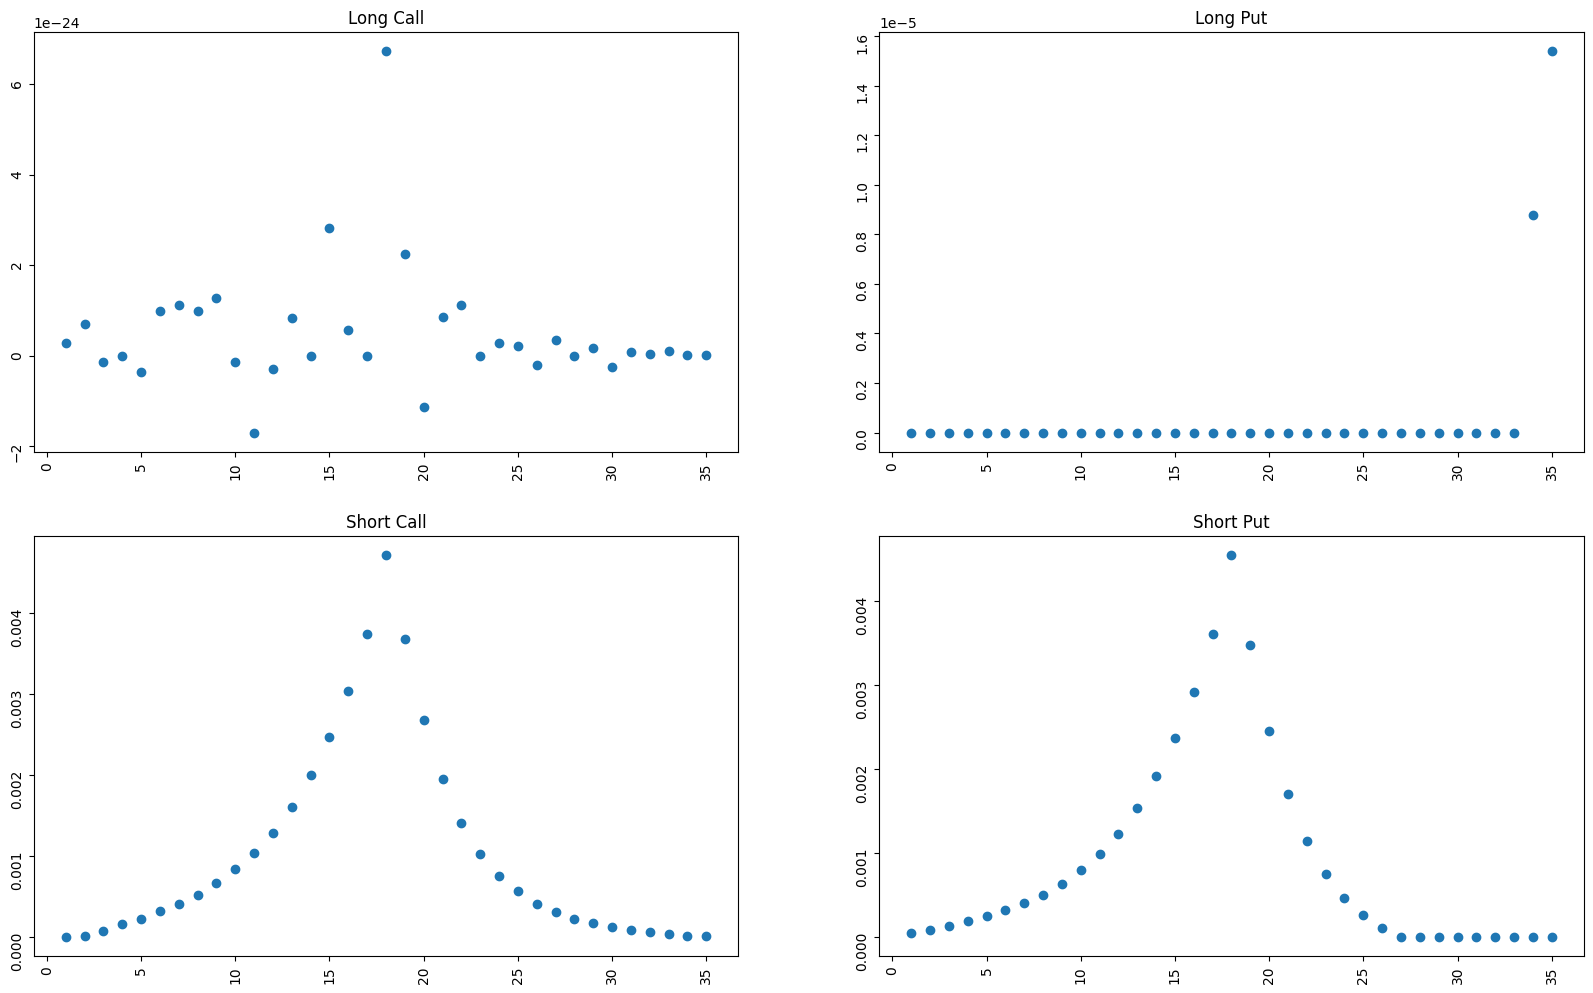

In [25]:
# Generate Sigma as a random PSD n*n matrix,  would be substituded by the covariance matrix
# mu as a random n-vector, would be substituded by the expected return

mu = option_PNL.mean().to_numpy()
n = len(mu)
Sigma = option_PNL.cov()
gamma = 0.05
lam = 1000000
Sigma_1 = Sigma + lam * np.identity(n)
Sigma_1 = cp.psd_wrap(Sigma_1)
h = np.zeros(n)

# Define and solve the CVXPY problem.
w = cp.Variable(n)
prob = cp.Problem(cp.Minimize((1/2) * gamma * cp.quad_form(w, Sigma_1) - mu.T @ w),
                 [
                    w >= h
                  ]
                  )
prob.solve()

# # Print result.
# print("\nThe optimal value is", prob.value)
# print("A solution w is")
# print(w.value)

# graph weights vs strike, see if at 1 it is a peak/valley
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,12))
ax[0][0].scatter(strike_rank[:35], w.value[:35])
ax[0][0].tick_params(labelrotation=90)
ax[0][0].set_title('Long Call')

ax[0][1].scatter(strike_rank[:35], w.value[35:70])
ax[0][1].tick_params(labelrotation=90)
ax[0][1].set_title('Long Put')

ax[1][0].scatter(strike_rank[:35], w.value[70:105])
ax[1][0].tick_params(labelrotation=90)
ax[1][0].set_title('Short Call')

ax[1][1].scatter(strike_rank[:35], w.value[105:])
ax[1][1].tick_params(labelrotation=90)
ax[1][1].set_title('Short Put')

plt.show()

In [26]:
Actual_NDX = PNL_data_filtered.groupby('quote_date')['NDX_Exp'].first().reset_index()
Forecast_NDX = PNL_data_filtered.groupby('quote_date')['implied_S_y'].first().reset_index()

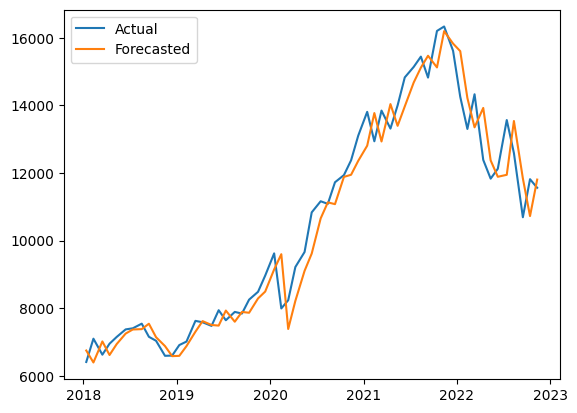

In [27]:
plt.plot(Actual_NDX["quote_date"], Actual_NDX["NDX_Exp"], label = "Actual")
plt.plot(Actual_NDX["quote_date"],Forecast_NDX["implied_S_y"], label = "Forecasted")
plt.legend()
plt.show()